<a href="https://colab.research.google.com/github/skywalker0803r/pa_0510/blob/V3/notebook/(surrogate%20model%20optimization)TPE%26NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

df_path = '/content/drive/MyDrive/南亞PA廠/cleaned_data/train_cleaned.csv'
tag_path = '/content/drive/MyDrive/南亞PA廠/cleaned_data/tag_cleaned.csv'
df = pd.read_csv(df_path,index_col=0)
tag = pd.read_csv(tag_path,index_col=0)
tag.head()

,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
0,1.0,MLPAP_TJC-0627.PV,OX預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,145,160,***
1,2.0,MLPAP_TRC-0610.PV,空氣預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,160,200,***
2,3.0,MLPAP_FR-0632.PV,汽機風量,流量,KNM3/HR,可控制因子,1分鐘2筆,64,85.4,****
3,4.0,MLPAP_FQ-0619.PV,OX入料量,流量,kg/HR,可控制因子,1分鐘2筆,2000,8000,****
4,5.0,MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,溫度,℃,可控制因子,1分鐘2筆,345,365,****


# INPUT

In [2]:
tag[tag.TAG.str.contains('0619.PV')]

,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
3,4.0,MLPAP_FQ-0619.PV,OX入料量,流量,kg/HR,可控制因子,1分鐘2筆,2000,8000,****


# OUTPUT

In [3]:
tag[tag.TAG.str.contains('0997.PV')]

,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
25,26.0,MLPAP_FQI-0997.PV,粗PA出料量,流量,KG/HR,不可控制因子,1分鐘2筆,2000,8800,***


# columns

In [4]:
x_col = tag[tag.TAG.str.contains('0619.PV')].TAG.tolist()
y_col = tag[tag.TAG.str.contains('0997.PV')].TAG.tolist()
x_col,y_col

(['MLPAP_FQ-0619.PV'], ['MLPAP_FQI-0997.PV'])

# visualization

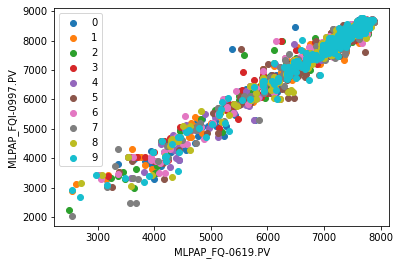

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(10):
  d = df.sample(1000,random_state=i)
  plt.scatter(d[x_col[0]].values,d[y_col[0]].values,label=str(i))
plt.xlabel(x_col[0])
plt.ylabel(y_col[0])
plt.legend()
plt.show()

In [6]:
from numpy.linalg import inv
from tqdm import tqdm_notebook as tqdm
w_list = []
b_list = []
for i in tqdm(range(1000)):
  d = df[x_col+y_col].dropna(axis=0).sample(1000,random_state=i)
  A = d[x_col]
  A['bias'] = 1
  A = A.values
  b = d[y_col].values
  w = inv(A.T@A)@A.T@b
  w_list.extend(w[0])
  b_list.extend(w[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


# weight

1.1575996945283165


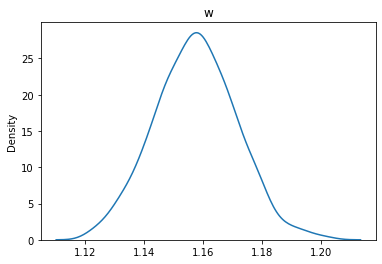

In [7]:
sns.kdeplot(w_list)
wm = np.mean(w_list)
plt.title('w')
print(wm)

# bias

-416.47623385366427


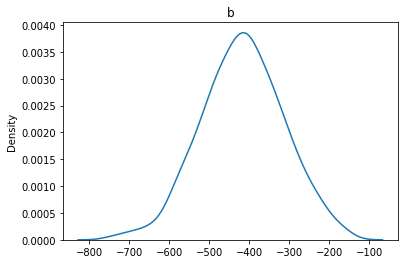

In [8]:
sns.kdeplot(b_list)
bm = np.mean(b_list)
plt.title('b')
print(bm)

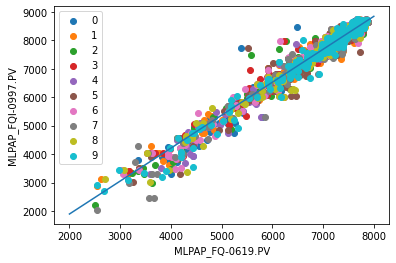

In [9]:
x = np.linspace(2000,8000,1000)
y = x*wm+bm
plt.plot(x,y)
for i in range(10):
  d = df.sample(1000,random_state=i)
  plt.scatter(d[x_col[0]].values,d[y_col[0]].values,label=str(i))
plt.xlabel(x_col[0])
plt.ylabel(y_col[0])
plt.legend()
plt.show()

# class F

In [10]:
class F(object):
  def __init__(self,w,b):
    self.w = w
    self.b = b
  def __call__(self,x):
    return x*self.w+self.b

f = F(wm,bm)
d = df[x_col+y_col].dropna(axis=0).sample(1000)
x = d[x_col[0]].values
y = d[y_col[0]].values
y_hat = f(x)

from sklearn.metrics import r2_score
r2_score(y,y_hat)

0.9559316435365404

# Unit_consumption

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


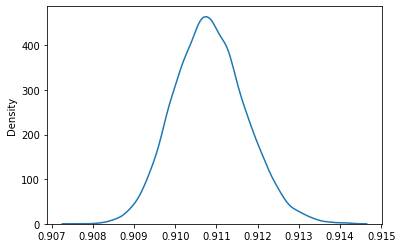

In [11]:
#Unit_consumption
uc_lst = []
d = df[x_col+y_col].dropna(axis=0)
for i in tqdm(range(10000)):
  s = d.sample(1000,random_state=i)
  uc = np.mean(s[x_col[0]].values/s[y_col[0]].values)
  uc_lst.append(uc)
sns.kdeplot(uc_lst)

# Unit_consumption criteria

In [12]:
uc_criteria = np.mean(uc_lst).round(4)
uc_criteria

0.9108

In [13]:
df['Unit_consumption'] = df[x_col[0]].values/df[y_col[0]].values
df[['Unit_consumption']].sample(5)

,Unit_consumption
2017-11-09 22:50:00,0.923502
2017-03-13 20:00:00,0.913145
2017-10-13 21:50:00,0.914575
2017-09-02 01:50:00,0.911675
2018-10-14 10:20:00,0.913662


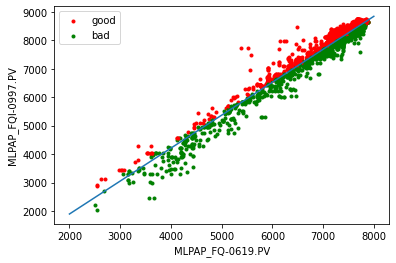

In [14]:
x = np.linspace(2000,8000,1000)
y = x*wm+bm
plt.plot(x,y)
for i in range(10):
  d = df.sample(1000,random_state=i)
  good = d[d['Unit_consumption'] < uc_criteria]
  bad = d[d['Unit_consumption'] > uc_criteria]
  if i == 0:
    plt.scatter(good[x_col[0]].values,good[y_col[0]].values,color='red',marker='.',label='good')
    plt.scatter(bad[x_col[0]].values,bad[y_col[0]].values,color='green',marker='.',label='bad')
  else:
    plt.scatter(good[x_col[0]].values,good[y_col[0]].values,color='red',marker='.')
    plt.scatter(bad[x_col[0]].values,bad[y_col[0]].values,color='green',marker='.')
plt.xlabel(x_col[0])
plt.ylabel(y_col[0])
plt.legend()
plt.show()

# boxplot good_op & bad_op

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


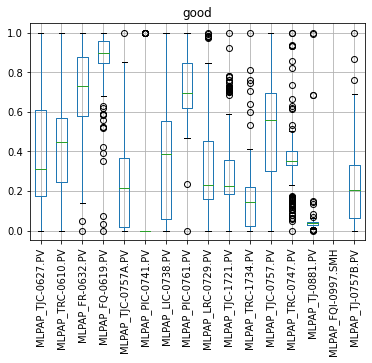

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


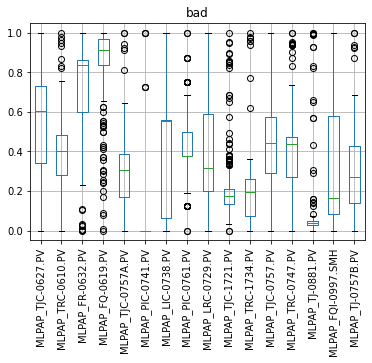

In [16]:
d = df.sample(1000)

good = d[d['Unit_consumption'] < uc_criteria]
bad = d[d['Unit_consumption'] > uc_criteria]

good = (good - good.min())/(good.max()-good.min())
bad = (bad - bad.min())/(bad.max()-bad.min())

good.boxplot(column=tag[tag.category=='可控制因子'].TAG.tolist(),rot=90)
plt.title('good')
plt.show()

bad.boxplot(column=tag[tag.category=='可控制因子'].TAG.tolist(),rot=90)
plt.title('bad')
plt.show()

# select_features by p_value

0    OX預熱器出口溫度
Name: chinese, dtype: object
p_value: 4.531176013742915e-40
p value <0.05?: True


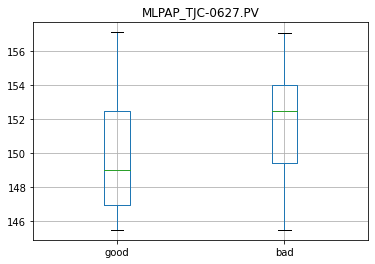

1    空氣預熱器出口溫度
Name: chinese, dtype: object
p_value: 0.13440999833669506
p value <0.05?: False


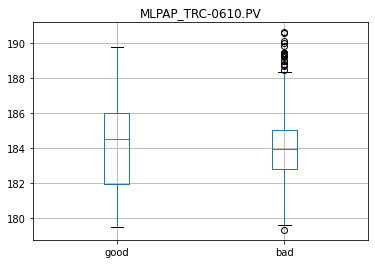

2    汽機風量
Name: chinese, dtype: object
p_value: 0.004845818663242885
p value <0.05?: True


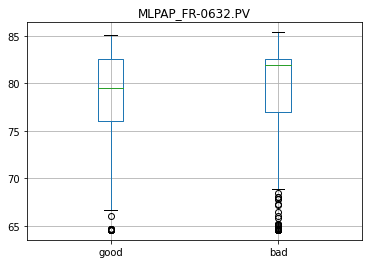

3    OX入料量
Name: chinese, dtype: object
p_value: 3.120660161503551e-08
p value <0.05?: True


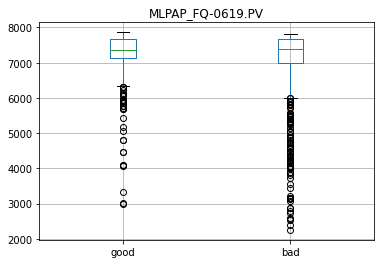

4    反應槽鹽浴溫度
Name: chinese, dtype: object
p_value: 2.143237021959214e-36
p value <0.05?: True


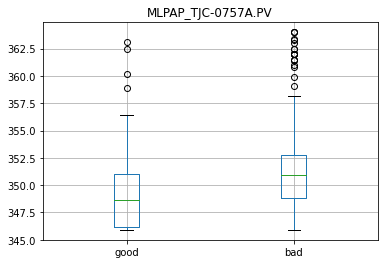

5    汽鼓(V211)鍋爐水壓力
Name: chinese, dtype: object
p_value: 6.305502114756891e-05
p value <0.05?: True


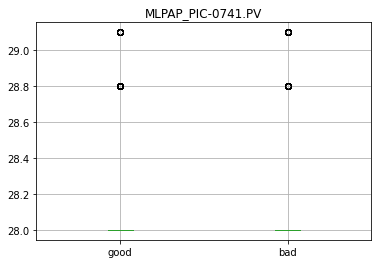

6    汽鼓(V211)鍋爐水液位
Name: chinese, dtype: object
p_value: 1.0971663698808914e-64
p value <0.05?: True


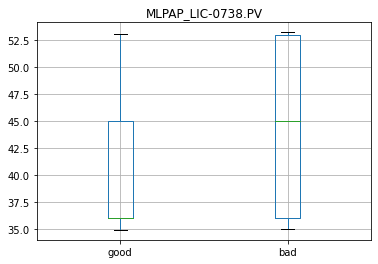

7    鹽浴冷卻器(E212)出口壓力
Name: chinese, dtype: object
p_value: 7.695548101824086e-13
p value <0.05?: True


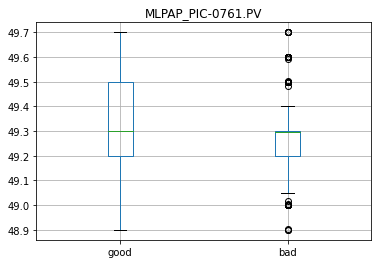

9    鍋爐水液位控制
Name: chinese, dtype: object
p_value: 5.4068321279193096e-24
p value <0.05?: True


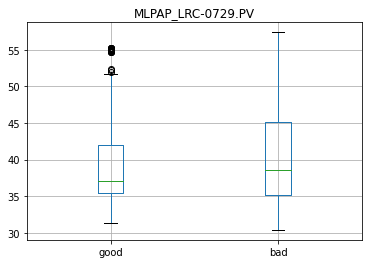

10    轉換式冷凝器冷油溫度
Name: chinese, dtype: object
p_value: 0.042729087223879074
p value <0.05?: True


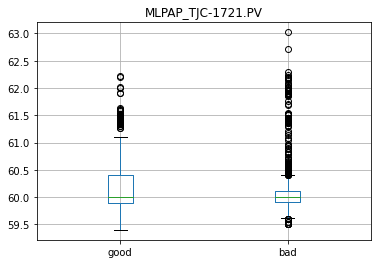

11    轉換式冷凝器熱油溫度
Name: chinese, dtype: object
p_value: 1.6666151429361613e-05
p value <0.05?: True


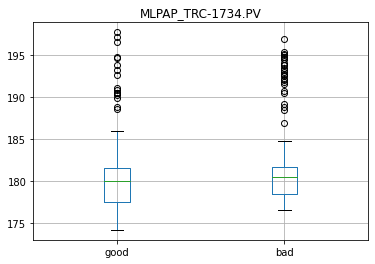

88    反應器A/B側鹽浴溫度差
Name: chinese, dtype: object
p_value: 4.5757142949171706e-14
p value <0.05?: True


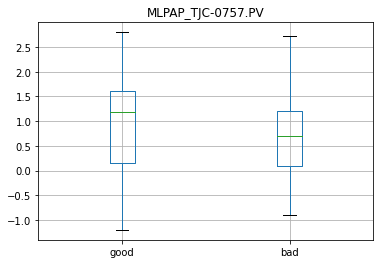

90    E220出口溫度
Name: chinese, dtype: object
p_value: 8.29400141180226e-12
p value <0.05?: True


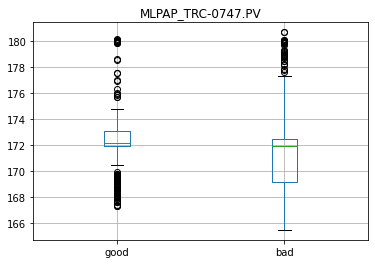

91    液態冷凝器出口溫度
Name: chinese, dtype: object
p_value: 0.00010778885450993176
p value <0.05?: True


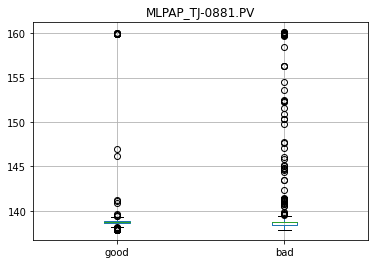

error MLPAP_FQI-0997.SMH
95    反應槽鹽浴溫度
Name: chinese, dtype: object
p_value: 5.4107893550533176e-24
p value <0.05?: True


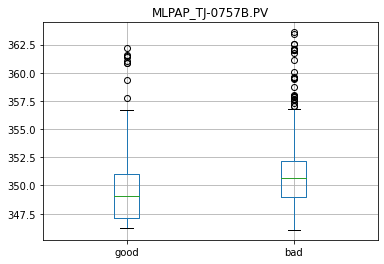

In [31]:
from scipy import stats
select_features = []
for i in tag[tag.category=='可控制因子'].TAG.tolist():
  try:
    # sample data
    d = df[[i]+['Unit_consumption']].dropna(axis=0).sample(10000)
    # good data
    good = d[d['Unit_consumption'] < uc_criteria]
    # bad data
    bad = d[d['Unit_consumption'] > uc_criteria]
    # compute p_value
    two_data = pd.DataFrame()
    two_data['good'] = good[i].sample(1000).values
    two_data['bad'] = bad[i].sample(1000).values
    _ ,p_value = stats.ttest_ind(two_data['good'] ,two_data['bad'])
    print(tag[tag.TAG==i]['chinese'])
    print('p_value:',p_value)
    print('p value <0.05?:',p_value<0.05)
    if p_value < 0.05:
      select_features.append(i)
    # plot
    two_data.boxplot()
    plt.title(i)
    plt.show()
  except:
    print('error',i)

# not select_features

In [35]:
set(tag[tag.category=='可控制因子'].TAG.tolist())^set(select_features)

{'MLPAP_FQI-0997.SMH', 'MLPAP_TRC-0610.PV'}

# neural network modeling

In [37]:
!pip install autorch > log.txt

In [40]:
import autorch

In [49]:
df[x_col+y_col].dropna(axis=0).describe().loc[['min','max']]

,MLPAP_TJC-0627.PV,MLPAP_FR-0632.PV,MLPAP_FQ-0619.PV,MLPAP_TJC-0757A.PV,MLPAP_PIC-0741.PV,MLPAP_LIC-0738.PV,MLPAP_PIC-0761.PV,MLPAP_LRC-0729.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_TJC-0757.PV,MLPAP_TRC-0747.PV,MLPAP_TJ-0881.PV,MLPAP_TJ-0757B.PV,MLPAP_FQI-0997.PV
min,148.899994,64.562805,3203.920776,348.799988,28.0,44.862982,48.900002,33.332964,59.134216,174.50,-1.100000,164.631859,137.800003,348.778320,3050.500000
max,157.122787,84.715805,7704.671143,356.399994,29.1,53.310034,49.599998,57.400002,63.076637,197.25,1.733582,175.000000,156.300003,356.753296,8755.637695


  0%|          | 1/300 [00:01<06:34,  1.32s/it]

epoch:0 train_loss:0.0015 valid_loss:0.0003


 17%|█▋        | 51/300 [01:07<05:56,  1.43s/it]

epoch:50 train_loss:0.0002 valid_loss:0.0001


 34%|███▎      | 101/300 [02:23<05:09,  1.56s/it]

epoch:100 train_loss:0.0001 valid_loss:0.0001


 50%|█████     | 151/300 [03:51<04:49,  1.94s/it]

epoch:150 train_loss:0.0001 valid_loss:0.0001


 67%|██████▋   | 201/300 [05:43<04:04,  2.47s/it]

epoch:200 train_loss:0.0001 valid_loss:0.0001


 84%|████████▎ | 251/300 [07:50<02:04,  2.54s/it]

epoch:250 train_loss:0.0001 valid_loss:0.0001


100%|██████████| 300/300 [09:56<00:00,  1.99s/it]


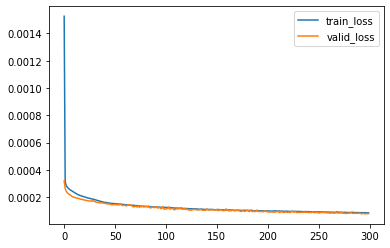

In [42]:
x_col = select_features
y_col = tag[tag.TAG.str.contains('0997.PV')].TAG.tolist()
nn = autorch.utils.PartBulider(df[x_col+y_col].dropna(axis=0),x_col,y_col)
nn.train()

In [44]:
nn.test()

,R2,MSE,MAPE
MLPAP_FQI-0997.PV,0.993204,5081.61,0.60959
AVG,0.993204,5081.61,0.60959


# nn forward test

p_value: Ttest_indResult(statistic=-0.005124142254603243, pvalue=0.9959167029021416)


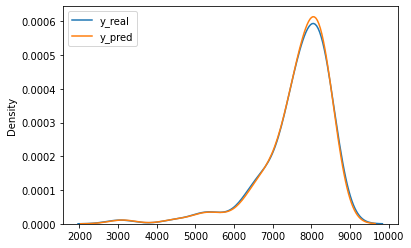

In [58]:
y_real = []
y_pred = []
for i in range(100):
  sample = df[x_col+y_col].dropna(axis=0).sample(1,random_state=i)
  x = sample[x_col]
  y = sample[y_col]
  y_real.append(y.values[0][0])
  y_pred.append(nn.predict(x).values[0][0])
sns.kdeplot(y_real,label='y_real')
sns.kdeplot(y_pred,label='y_pred')
print('p_value:',stats.ttest_ind(y_real,y_pred))
plt.legend()
plt.show()

# save nn

In [60]:
import joblib
nn.shrink()
joblib.dump(nn,'/content/drive/MyDrive/南亞PA廠/model/Critic_2.pkl')

['/content/drive/MyDrive/南亞PA廠/model/Critic_2.pkl']

In [61]:
!pip install optuna > log.txt

# surrogate model optimization by Tree-structured Parzen Estimator and neural network

In [65]:
x_col_range = df[x_col+y_col].dropna(axis=0)[x_col].describe().loc[['min','max']]
x_col_range

,MLPAP_TJC-0627.PV,MLPAP_FR-0632.PV,MLPAP_FQ-0619.PV,MLPAP_TJC-0757A.PV,MLPAP_PIC-0741.PV,MLPAP_LIC-0738.PV,MLPAP_PIC-0761.PV,MLPAP_LRC-0729.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_TJC-0757.PV,MLPAP_TRC-0747.PV,MLPAP_TJ-0881.PV,MLPAP_TJ-0757B.PV
min,148.899994,64.562805,3203.920776,348.799988,28.0,44.862982,48.900002,33.332964,59.134216,174.50,-1.100000,164.631859,137.800003,348.778320
max,157.122787,84.715805,7704.671143,356.399994,29.1,53.310034,49.599998,57.400002,63.076637,197.25,1.733582,175.000000,156.300003,356.753296


In [160]:
import optuna

request = {} 
request['output'] = 8200
request['unit_consumption'] = 0.89

def objective(trial: optuna.Trial):
  Input_df = pd.DataFrame(index=[0],columns=x_col)
  for key in x_col:
    Input_df.loc[0,key] = trial.suggest_uniform(name=key,low=x_col_range.loc['min',key],high=x_col_range.loc['max',key])
  output_df = nn.predict(Input_df)
  output = output_df.values[0][0]
  feed = Input_df.loc[0,'MLPAP_FQ-0619.PV']
  loss1 = (request['output']-output)**2
  loss2 = ((feed/output)-request['unit_consumption'])**2
  total_loss = loss1 + loss2
  return total_loss

study = optuna.create_study()
study.optimize(objective, n_trials=250)

[I 2021-01-13 08:00:30,445] A new study created in memory with name: no-name-0c84bb63-6ec7-498a-b396-8a404d72a3b8
[I 2021-01-13 08:00:30,470] Trial 0 finished with value: 10670421.003244821 and parameters: {'MLPAP_TJC-0627.PV': 152.73962652940466, 'MLPAP_FR-0632.PV': 76.80873131887451, 'MLPAP_FQ-0619.PV': 3982.6322728775963, 'MLPAP_TJC-0757A.PV': 350.87186030999464, 'MLPAP_PIC-0741.PV': 28.28353888743185, 'MLPAP_LIC-0738.PV': 50.03021490611848, 'MLPAP_PIC-0761.PV': 49.1406182961935, 'MLPAP_LRC-0729.PV': 43.77685756165327, 'MLPAP_TJC-1721.PV': 59.861573759665745, 'MLPAP_TRC-1734.PV': 191.41887727325462, 'MLPAP_TJC-0757.PV': -0.09590119846732037, 'MLPAP_TRC-0747.PV': 172.33497004168152, 'MLPAP_TJ-0881.PV': 147.37798716816863, 'MLPAP_TJ-0757B.PV': 354.3239723186302}. Best is trial 0 with value: 10670421.003244821.
[I 2021-01-13 08:00:30,483] Trial 1 finished with value: 16373956.784872811 and parameters: {'MLPAP_TJC-0627.PV': 154.09889911280325, 'MLPAP_FR-0632.PV': 66.59172524833843, 'MLP

# best_params

In [161]:
study.best_params

{'MLPAP_FQ-0619.PV': 7103.771270146813,
 'MLPAP_FR-0632.PV': 83.86288824980834,
 'MLPAP_LIC-0738.PV': 47.2800648769839,
 'MLPAP_LRC-0729.PV': 37.82899199013748,
 'MLPAP_PIC-0741.PV': 28.963285981174128,
 'MLPAP_PIC-0761.PV': 49.01191677744593,
 'MLPAP_TJ-0757B.PV': 350.9266014395572,
 'MLPAP_TJ-0881.PV': 139.55136777489733,
 'MLPAP_TJC-0627.PV': 156.11646850585961,
 'MLPAP_TJC-0757.PV': 0.10355259620890106,
 'MLPAP_TJC-0757A.PV': 350.70512334912013,
 'MLPAP_TJC-1721.PV': 61.94809793053865,
 'MLPAP_TRC-0747.PV': 168.41137271003095,
 'MLPAP_TRC-1734.PV': 194.2844388676389}

# predict output

In [162]:
nn.predict(pd.DataFrame(study.best_params,index=[0])).values[0][0]

8200.139

# predict Unit_consumption

In [163]:
study.best_params['MLPAP_FQ-0619.PV']/nn.predict(pd.DataFrame(study.best_params,index=[0])).values[0][0]

0.8662989193721162